In [1]:
from kagglehub import KaggleDatasetAdapter
import os
import kagglehub
import pandas as pd

# Download latest version
data = (kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "armitaraz/chatgpt-reddit",
    "chatgpt-reddit-comments.csv")
        .dropna())

data.tail()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
52410,16667,j4lbiix,t1_j4kgcac,"Scary thing is, in this future text won’t be t...",r/technology
52411,16668,j5m0v6m,t3_10jmvpj,"Read the T.O.S., you'll thank me later",r/technology
52412,16669,j5m6aj0,t1_j5m0v6m,What am I missing here... https://openai.com/t...,r/technology
52413,16670,j5nylax,t1_j5m0v6m,What does ChatGTP think of its own TOS?,r/technology
52414,16671,j5mwpdr,t1_j5m6aj0,Don't know what they're referring to in the TO...,r/technology


In [2]:
docs = data["comment_body"]
categories = data["subreddit"]

In [3]:
from narrativegraphs import CooccurrenceGraph
from narrativegraphs.nlp.tuplets.cooccurrences import DocumentCooccurrenceExtractor

if os.path.exists("chatgpt_reddit.db"):
    model = CooccurrenceGraph.load("chatgpt_reddit.db")
else:
    model = CooccurrenceGraph(
        cooccurrence_extractor=DocumentCooccurrenceExtractor(),
        sqlite_db_path="chatgpt_reddit.db",
        on_existing_db="overwrite",
        n_cpu=-1
    ).fit(docs)

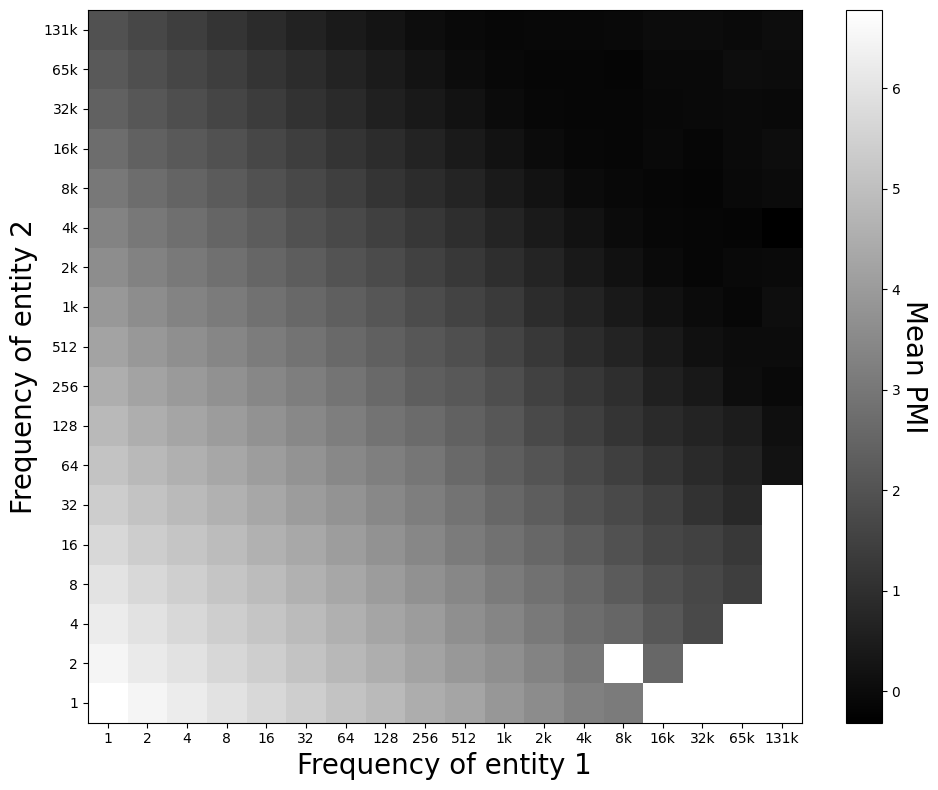

In [7]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

In [11]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=3,
    minimum_edge_doc_frequency=3,
    maximum_edge_doc_frequency=100,
    minimum_node_frequency=5,
    maximum_node_frequency=100
)

In [16]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=2,
    community_detection_method_args=dict(k=4)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print("COMM", *[e.label for e in comm.members], sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

COMM, the fuss, 900,000 credits, 900,000 for $, bypass scripts
ID: 1612, OFFSET: 0
900,000 credits costs $18. I can get you 900,000 for $5. I also sell bypass scripts so you don't have to fuss with the content filter and ChatGPT giving you a fuss over certain requests
ID: 2067, OFFSET: 0
900,000 credits costs $18. I can get you 900,000 for $5. I also sell bypass scripts so you don't have to fuss with the content filter and ChatGPT giving you a fuss over certain requests
ID: 3327, OFFSET: 0
900,000 credits costs $18. I can get you 900,000 for $5. I also sell bypass scripts so you don't have to fuss with the content filter and ChatGPT giving you a fuss over certain requests
ID: 10575, OFFSET: 0
900,000 credits costs $18. I can get you 900,000 for $5. I also sell bypass scripts so you don't have to fuss with the content filter and ChatGPT giving you a fuss over certain requests
ID: 14153, OFFSET: 0
900,000 credits costs $18. I can get you 900,000 for $5. I also sell bypass scripts so you 

In [15]:
>comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=2,
    community_detection_method_args=dict(resolution=5)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print("COMM", *[e.label for e in comm.members], sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

COMM, Razor, Occam
ID: 5526, OFFSET: 0
I'd say Occam's Razor implies the opposite of your conclusion. Bigger number,  more computational power => better model, especially given it has worked this way in the past.
ID: 5568, OFFSET: 0
 People love to be snobby about Occam's razor because at some point, the idea that it's overused became trendy. The guy ended up saying that Occam's razor has no place in machine learning. I was right, he has no clue what he's talking about and was just looking for a moment to catch me off guard. I don't give a damn that I don't sound like Jesus Christ on a messaging board that's all about getting internet points.
ID: 5592, OFFSET: 0
Honestly, nothing about what you say is wrong, except when you call it Occam's razor lol. Occam's Razor is literally just a means whittling down explanations of something. It is quite literally unrelated. The phrase you are probably trying to say is diminishing returns...
ID: 5612, OFFSET: 0
No I'm going to be very clear now. I

In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()